<h1 style="text-align:center"> Predicting Boston Housing Prices using a K-Nearest Neighbours Regression Algorithm </h1>

While I was learning about various machine learning algorithms with Codecademy, I undertook a few practice projects which used the toy data sets provided by the scikit-learn folks to make sure I understood how to implement those algorithms. For this project, I wanted to practice implementing a K-Nearest Neighbours (KNN) Regression algorithm to predict the median house value of an owner-occupied home in suburban Boston, for a historical data set which dates to the 1970s. As I understand it, KNN Regression is an extension of the KNN algorithm I used for my wine recognition classification project; it's just that  now instead of returning a classification, the algorithm returns a numerical estimate for some target value. The algorithm still relies on calculating a distance between neighbouring points, which I will readily be able to do with the 13 numerical features provided in scikit-learn's Boston housing data set. Most of that data seems to be continuous, but there is one feature -- whether or not the home is located near the Charles River -- which is binary, either a 0 or a 1. It will be interesting to see how using this classification-data-converted-to-a-numerical-value impacts the KNN Regression algorithm. And to see how these results compare with something I've already done, I will also fit a multi-variable linear regression model to the data to see how its performance compares to the KNN Regression model's performance. My criterion for comparison will be the model's coefficient of determination, i.e. "goodness of fit", which quantifies how well the model's predictions match the values in the test/validation set I will set aside from the rest of the data.

From the documentation provided by the scikit-learn folks, I've been able to learn that this Boston-area housing data comes from the 1970s (hence the low median house values, at least compared to the current market), and from the paper citation they offer it appears to have been part of a study to determine if air quality impacts house values. As I understand it, this data set is a fairly well-known data set that's used for testing regression algorithms. This makes it ideal for practicing my KNN Regression skills.

Before I dive into building the KNN Regression model, I should give some credit to the folks who compiled the data set I'm about to use and to the scikit-learn folks who made it available through their open-source software package. <br>
Let's start with a citation to the scikit-learn folks: <br>
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011 <br>
and, of course, their main website: https://scikit-learn.org/stable/index.html.<br>
The papers cited by the scikit-learn folks are:<br>
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. ‘Hedonic prices and the demand for clean air’, J. Environ. Economics & Management, vol.5, 81-102, 1978. <br>
Used in Belsley, Kuh & Welsch, ‘Regression diagnostics …’, Wiley, 1980. N.B. <br>
To gain more information about the Boston housing data set, I consulted with https://www.oreilly.com/library/view/python-machine-learning/9781783555130/ch10s02.html and https://www.engineeringbigdata.com/boston-dataset-scikit-learn-machine-learning-in-python/; from the latter, I got the idea to do a few visualizations before implementing the KNN Regression and multi-variable linear regression models.


<h1> Loading the Data and Data Analysis Packages </h1>

In [1]:
# First, import the data itself:
from sklearn.datasets import load_boston

# Then import various data analysis packages:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Now we can load the Boston housing data into a "bunch:"
boston_housing_data = load_boston()  

The first thing you'll see in the cell below is a call to print() to print out the file description. I did this to get some basic information about what the data set contains and where it originated. I've commented this line out so as not to clog up the cell output.

You'll also notice a commented-out call to print out the data feature names; I did this to see what is in the actual data portion of the data set. Since there are only 13 feature names, I assume that this corresponds to the 13 predictive/numeric "attributes" in the description file.

The thing I'm interested in predicting, namely median house value, seems to be stored in "target." It is referred to as "attribute 14" in the description file, which is a bit confusing because it's not actually with the other 13 attributes in the "data" DataFrame. 

Anyway. After those two commented-out calls to print(), I collect the data into a DataFrame and Series to be used for further analysis.


In [3]:
#print(boston_housing_data.DESCR)
#print(boston_housing_data.feature_names)

# Collect a list of what I want to call the columns in the "actual" data DataFrame:
bh_columns=['percapcrimerate', 'zone', 'industrialacres', 'nearcharlesriver', 'nitricoxconcen', 'avgrooms', \
            'percentb41940', 'distancetowork', 'highwaynearby', 'fullvaluetaxrate', 'sttratio', \
            'minoritymeasure','lowerstatus']

# Separate out the "actual" data into a DataFrame:
bh_data = boston_housing_data.data
bh_data = pd.DataFrame(bh_data, columns = bh_columns)
#print(bh_data.info())

# Assign the "target" data a convenient variable name:
bh_target = boston_housing_data.target
#print(bh_target)

<h1> Visualizing the Boston Housing Data </h1>

I got the following idea from https://www.engineeringbigdata.com/boston-dataset-scikit-learn-machine-learning-in-python/, so a quick shout-out to them.

It might be nice to have a look at this data. What is the distribution of median house values? Are any of the features in "bh_data" linearly correlated with median house value? The best way to find out is to plot the data, so I will go ahead and do that.

First, let's look at the distribution of median house values. I'll make a histogram of that.

Text(0.5, 1.0, 'Distribution of Median House Values for the Boson Data Set')

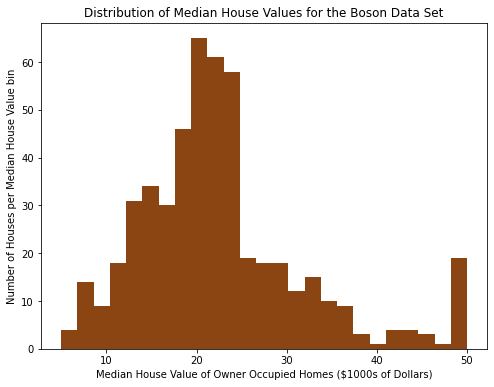

In [4]:
plt.figure(figsize=(8,6))
plt.hist(bh_target, bins = 25, color = 'saddlebrown')
plt.xlabel('Median House Value of Owner Occupied Homes ($1000s of Dollars)')
plt.ylabel('Number of Houses per Median House Value bin')
plt.title('Distribution of Median House Values for the Boson Data Set')

The distribution of median house values looks ... almost Gaussian, save for that spike at $50,000. While I fully admit that I don't know what precisely I expected the distribution to look like, I know I didn't expect it to look almost Gaussian. Flat maybe, or even bi- or multi-modal, but definitely not almost Gaussian. That by itself is quite interesting.

Well, now that I've looked at the median house value distribution, I should see if anything seems to be linearly correlated with median house value. This may be a bit of overkill, and it's a bit to scroll through in the output cell, but I am kind of proud of myself for figuring out how to set the plot output up like this: it saves me an awful lot of repetitive typing!

Text(0.5, 1.01, 'Boston Housing Data Set Features vs. Median House Value')

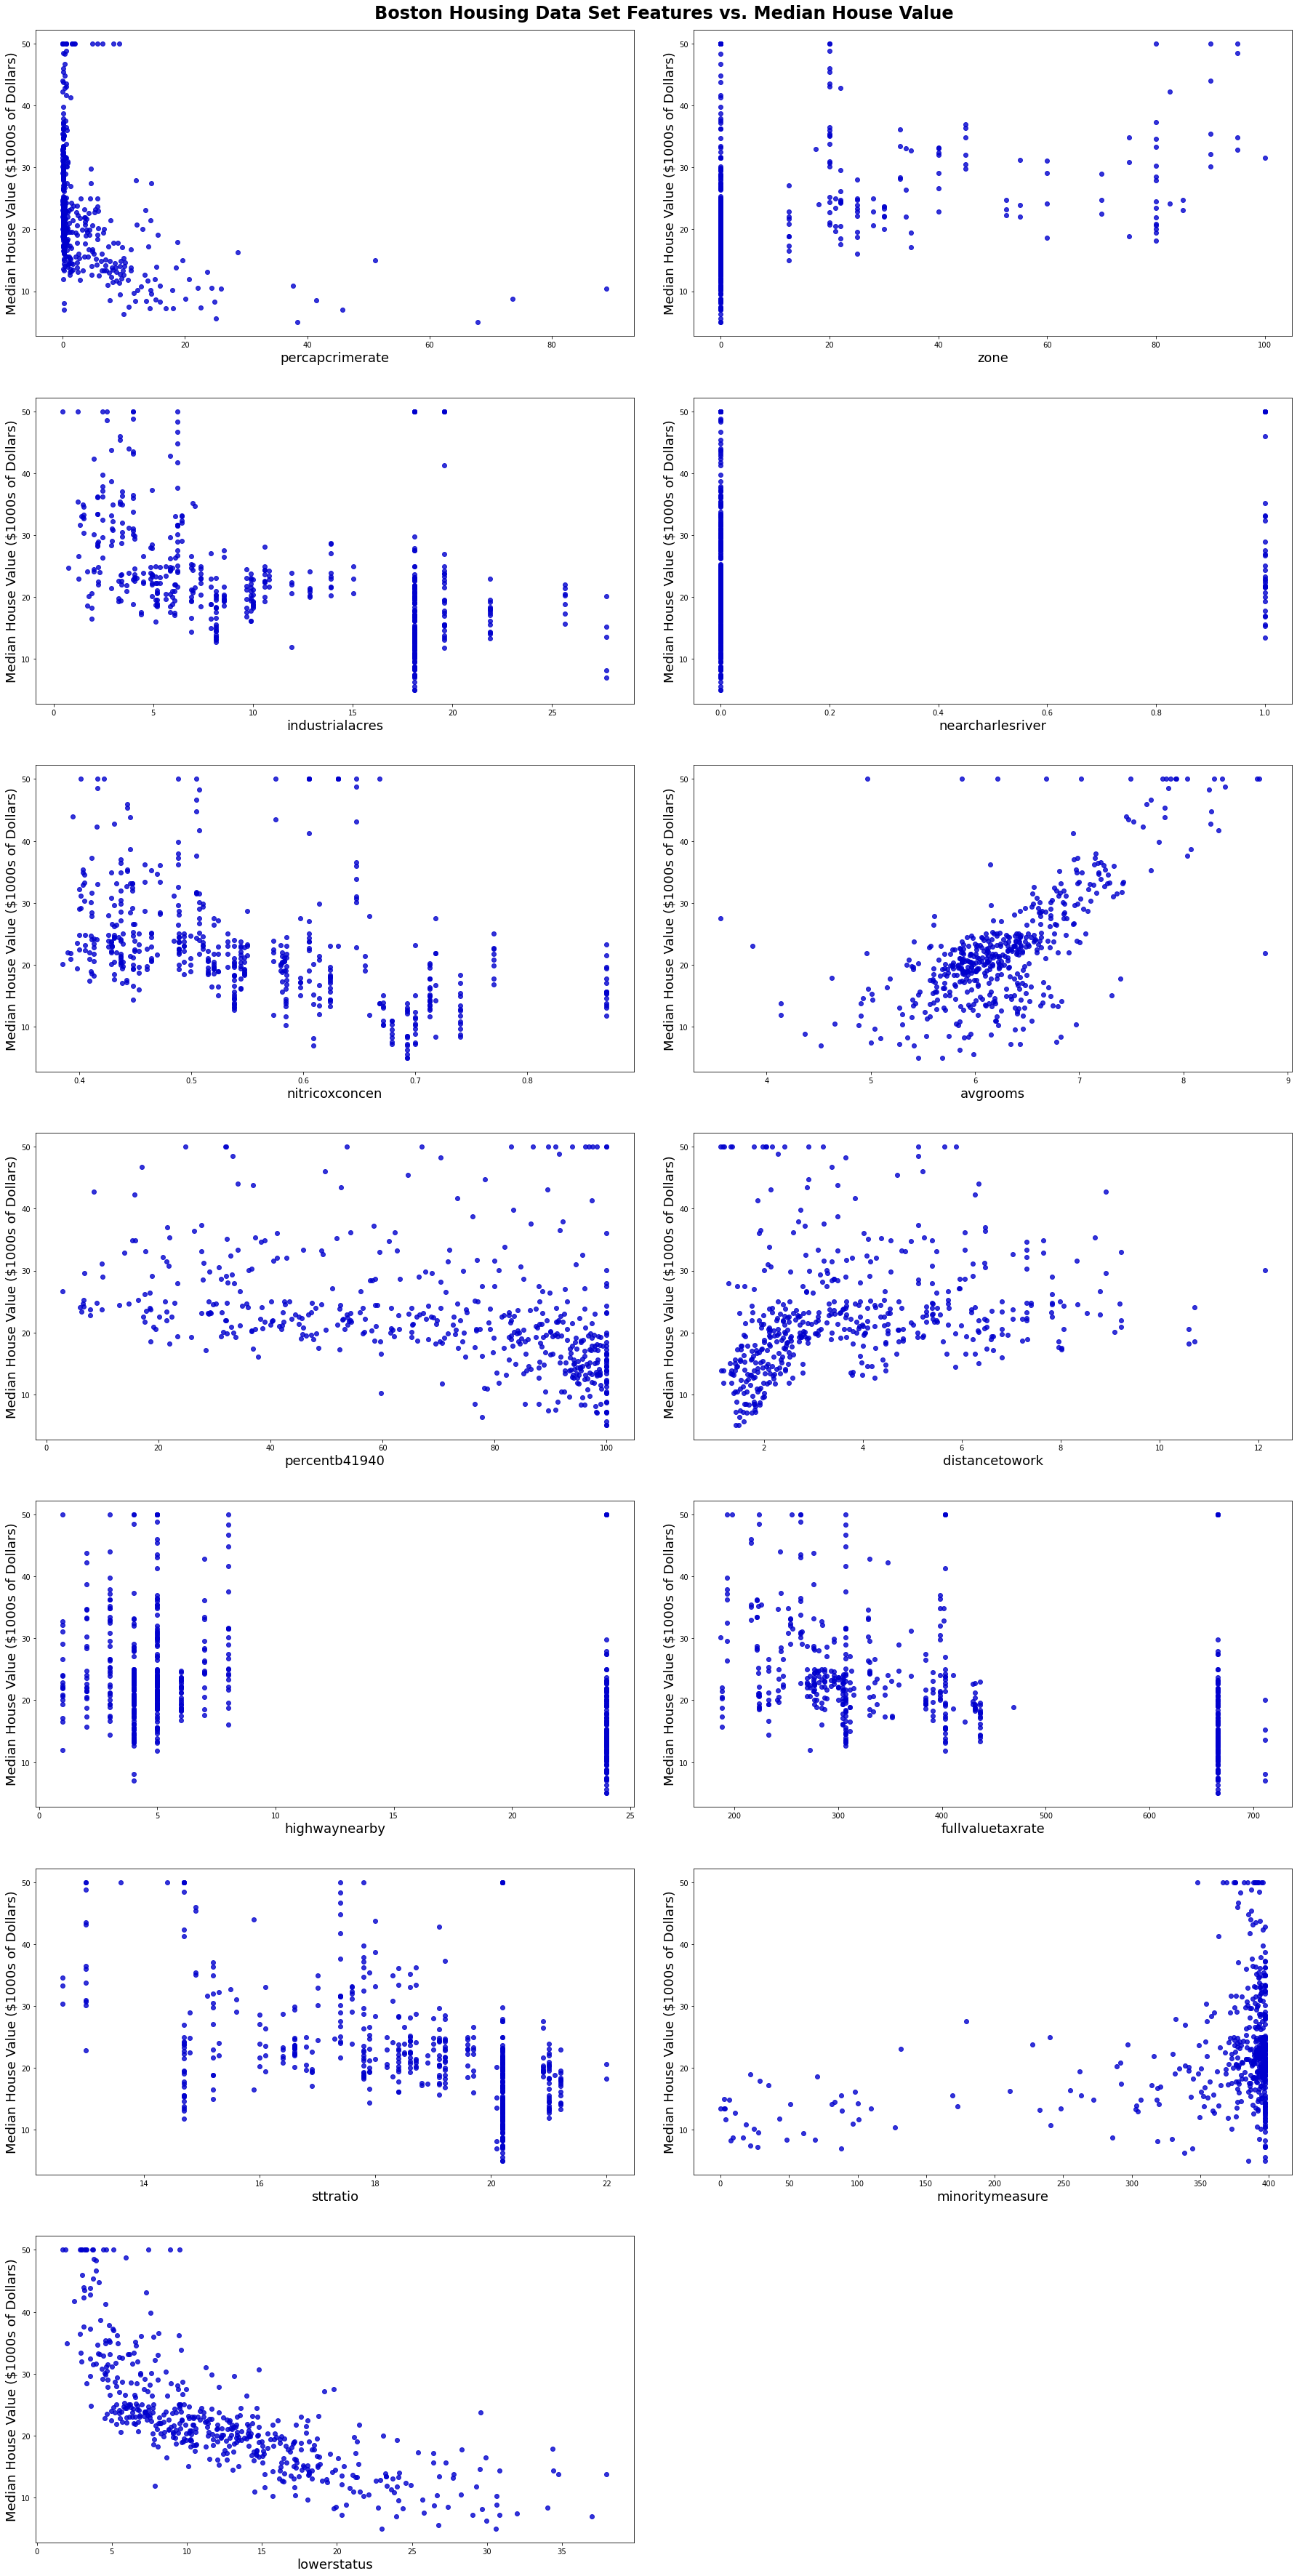

In [5]:
fig = plt.figure(figsize=(24,48))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.2, wspace = 0.1)
for i in range(13):
    cname = str(bh_columns[i])
    fig.add_subplot(7,2,i+1)
    plt.scatter(bh_data[cname], bh_target, alpha = 0.8, color = 'mediumblue')
    plt.xlabel(cname, fontsize=18)
    plt.ylabel('Median House Value ($1000s of Dollars)', fontsize=18)
plt.suptitle('Boston Housing Data Set Features vs. Median House Value', x = 0.5, y = 1.01, \
              fontsize=24, fontweight='bold')

The only downside of having plots of every feature vs. median house value in one figure is that the axis titles are a bit small and hard to read. I've tried to increase the font size of the axis titles themselves to help with this, but the <i>x</i>-axis tick mark labels are a bit small. <br>
Despite these limitations and shortcomings, some trends in the data can be seen. First of all, since the column "nearcharlesriver" has a value that's either 0 or 1, a plot of "nearcharlesriver" vs. median house value shows up as two vertical lines. Otherwise, it seems as though the columns "avgrooms" and "lowerstatus" are vaguely linearly-ish correlated with median house value; "distancetowork" and "percentb41940" do seem to be correlated with median house value, but it's definitely not anything resembling a linear correlation. None of the other columns seem to have any strong correlation with median house value.

<h1> Building Regression Models using All Data Features </h1>

Now that I've gotten the data into a DataFrame and the "targets" into a Series, made a plot of the median house value distribution, and constructed various scatter plots of data features vs. median house value, I should go about what I originally set out to do: namely, build KNN Regression and multi-variable linear regression models of the data.

First, though, I will split the data into a training set and a test/validation set. I'll use a split of 80% training, 20% test, and set a random state so that I get the same splitting of rows between training and test set each time I want to build a model.

In [6]:
feat_train_all, feat_test_all, values_train_all, values_test_all =  \
      train_test_split(bh_data, bh_target, train_size = 0.80, test_size = 0.20, random_state = 78)

I don't have to worry about scaling the data before passing it to a linear regression model -- indeed, I shouldn't do this as it will definitely affect the feature coefficients and intercept -- so I will build my linear regression model on the "raw" training data itself. I will then use the model to predict the values of houses in the test/validation data, and finally see what the coefficient of determination is.

In [8]:
# Build the linear regression model:
lin_regress_all = LinearRegression()
lin_regress_all.fit(feat_train_all, values_train_all)

# Predict median house values, and print out the coefficient of determination:
lg_all_predict = lin_regress_all.predict(feat_test_all)
print(lin_regress_all.score(feat_test_all, values_test_all))

0.7452210925673013


In the grand scheme of things, a coefficient of determination of 0.745 isn't too bad. But let's see if the KNN Regression model does any better. 

I definitely need to scale the data before handing it off to the KNN Regression algorithm (I explained why in my wine recognition KNN Classification project), and my scaling of choice here will be min/max scaling. I'll use the MinMaxScaler in the preprocessing package of scikit-learn to do this. When building my model, I will treat <i>k</i> as a free parameter, and select the <i>k</i> which maximizes the coefficient of determination as the value of <i>k</i> in my "final" model.

In [9]:
# Apply a min/max scaling to the data:
minmaxscale = MinMaxScaler()
scaled_feat_train_all = minmaxscale.fit_transform(feat_train_all)
scaled_feat_test_all = minmaxscale.transform(feat_test_all)

# An empty array to store model scores:
scores_all = []

# Loop over a range of ks, build a KNN Regression model, and calculate the coefficient of determination when applied 
# to the test/validation data:
for k in range(1,len(scaled_feat_train_all)+1):
    regressor = KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    regressor.fit(scaled_feat_train_all, values_train_all)
    scores_all.append(regressor.score(scaled_feat_test_all, values_test_all))

# Build the "final" model with the k which maximimzed the coefficient of determination:
all_regress = KNeighborsRegressor(n_neighbors = scores_all.index(max(scores_all))+1, weights = 'distance')
all_regress.fit(scaled_feat_train_all, values_train_all)

# Predict median house values, and print out the coefficient of determination:
all_values_predicts = all_regress.predict(scaled_feat_test_all)
all_regress_score = all_regress.score(scaled_feat_test_all, values_test_all)
print(all_regress_score)

0.804981217590724


Sure enough, the KNN Regression model <i>did</i> fare better than the multi-variable linear regression model, with a "goodness of fit" of 0.805 as opposed to 0.745. It's not a huge difference in coefficient of determination I admit, but enough of one for me to say that trying to predict median house value for this Boston housing data set is better done with a KNN Regression model than a multi-variable linear regression model. This makes qualitative sense to me, as I would assume that houses in the same neighbourhood have similar house values and so would tend to "cluster" together in the 13-dimension feature space of this model.

I'm curious to know if the trend of coefficient of determination with <i>k</i> matches what I expect, so I will go ahead and plot that to see what it looks like:

Text(0.5, 1.0, 'Coefficient of Determination as a Function of k')

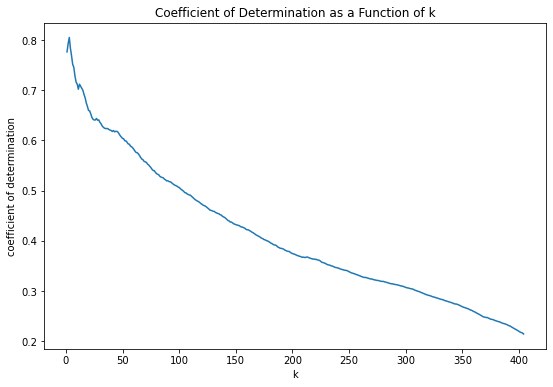

In [10]:
plt.figure(figsize=(9,6))
plt.plot(range(1,len(feat_train_all)+1),scores_all)
plt.xlabel('k')
plt.ylabel('coefficient of determination')
plt.title('Coefficient of Determination as a Function of k')

This behaviour matches approximately what I’d expect. In this plot, coefficient of determination increases with increasing <i>k</i> up to a maximum value; it then decreases with increasing <i>k</i>. I note that the model does start off (at <i>k</i> = 1) at a relatively high coefficient of determination, higher than what I was able to achieve with the multi-variable linear regression model.

<h1> Visualizing the Performance of the KNN Regression and Linear Regression Models for All Data Features </h1>

I already know that my KNN Regression model performs better in terms of goodness of fit than the linear regression model does, but it would be nice to visualize this as well. I took the following idea from some of the Codecademy regression projects I have completed: plot a scatter plot of actual vs. predicted median house value for each house in the test/validation set, along with an actual = predicted line. If the coefficient of determination was 1.0, all data points would fall on that line. Since neither of my models had a coefficient of determination of 1.0, not all data points will fall on that line, but it will be interesting to see what the spread about that line is. I'll plot linear regression prediction values in crimson and KNN Regression predictions in blue.

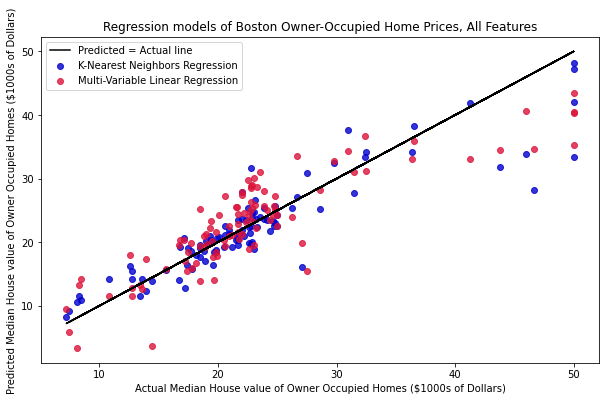

In [11]:
# Set up the actual = predicted line:
equal_line = values_test_all

# Plot actual vs. predicted values:
plt.figure(figsize=(10,6))
plt.scatter(values_test_all, all_values_predicts, color = 'mediumblue', alpha = 0.8)
plt.scatter(values_test_all, lg_all_predict, color = 'crimson', alpha = 0.8)
plt.plot(values_test_all, equal_line, color = 'black')
plt.xlabel('Actual Median House value of Owner Occupied Homes ($1000s of Dollars)')
plt.ylabel('Predicted Median House value of Owner Occupied Homes ($1000s of Dollars)')
plt.title('Regression models of Boston Owner-Occupied Home Prices, All Features')
plt.legend(['Predicted = Actual line','K-Nearest Neighbors Regression','Multi-Variable Linear Regression'])

Both models do a poor job of predicting median house value at high house value; the linear regression model also does a comparatively poor job at low house value. Between median house values of about \\$20,000 to about \\$30,000, there is a fair amount of scatter about the actual = predicted line; the linear regression model seems to be biased toward overestimating the actual median house value in this regime. The scatter of the KNN Regression model is a bit more symmetric about the predicted = actual line.

<h1> Building Regression Models using Selected Data Features </h1>

So far, using all of the data features, I have been able to build a multi-variable linear regression model whose coefficient of determination is 0.745 and a KNN Regression model whose coefficient of determination is 0.805. But can I do better? If I neglect some carefully chosen features, i.e. those which are not strongly correlated with median house value, could I increase my model performance? Let's find out.

In [12]:
# Select which features to include in the model. The below were selected through a trial and error process. These may
# not be the optimal in absolute terms set of features to include in the model, but they were the best I was able to 
# come up with.

features_1 = bh_data[['percapcrimerate', 'nitricoxconcen', 'avgrooms', 'highwaynearby', 'fullvaluetaxrate',\
                      'sttratio', 'lowerstatus']]

# As above, split the features into training and test/validation sets:
feat_train_1, feat_test_1, values_train_1, values_test_1 =  \
      train_test_split(features_1, bh_target, train_size = 0.80, test_size = 0.20, random_state = 78)

I need to build my multi-variable linear regression model before I scale the data:

In [13]:
# Build the linear regression model:
lin_regress_1 = LinearRegression()
lin_regress_1.fit(feat_train_1, values_train_1)

# Predict median house values, and print out the coefficient of determination:
lg_1_predict = lin_regress_1.predict(feat_test_1)
print(lin_regress_1.score(feat_test_1, values_test_1))

0.7011899903694887


Neglecting some of the data features actually made the multi-variable linear regression model fare <b>worse</b>! If my goal was to build the best linear regression model I could for this data, I would either keep all of the data features or choose a different subset than these particular ones. Let's see if carefully neglecting some features helps the KNN Regression model's coefficient of determination.

Once again, I need to scale the data before handing it off to the KNN Regression algorithm, and to keep things consistent I will once again do a min/max scaling using scikit-learn's MinMaxScaler. When building my model, I will again treat <i>k</i> as a free parameter, and select the <i>k</i> which maximizes the coefficient of determination as the value of <i>k</i> in my "final" model.

In [14]:
# Apply a min/max scaling to the data:
minmaxscale1 = MinMaxScaler()
scaled_feat_train_1 = minmaxscale1.fit_transform(feat_train_1)
scaled_feat_test_1 = minmaxscale1.transform(feat_test_1)

# An empty array to store model scores:
scores_1 = []

# Loop over a range of ks, build a KNN Regression model, and calculate the coefficient of determination when 
# applied to the test/validation data:
for k in range(1,len(scaled_feat_train_1)+1):
    regressor = KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    regressor.fit(scaled_feat_train_1, values_train_1)
    scores_1.append(regressor.score(scaled_feat_test_1, values_test_1))

# Build the "final" model with the k which maximimzed the coefficient of determination:
regress_1 = KNeighborsRegressor(n_neighbors = scores_1.index(max(scores_1))+1, weights = 'distance')
regress_1.fit(scaled_feat_train_1, values_train_1)

# Predict median house values, and print out the coefficient of determination:
values_predicts_1 = regress_1.predict(scaled_feat_test_1)
regress_score_1 = regress_1.score(scaled_feat_test_1, values_test_1)
print(regress_score_1)

0.8830096134814175


Sure enough, I have managed to achieve somewhat of an improvement in goodness of fit. By carefully selecting features to include in the KNN Regression model, I've been able to improve its coefficient of determination from 0.805 to 0.883. While it's not a huge improvement in goodness of fit, it is a noticeable one, so I conclude that neglecting certain data features has helped improve the model.

Let me make sure the trend of coefficient of determination with <i>k</i> doesn't look too different from the previous one:

Text(0.5, 1.0, 'Coefficient of Determination as a Function of k')

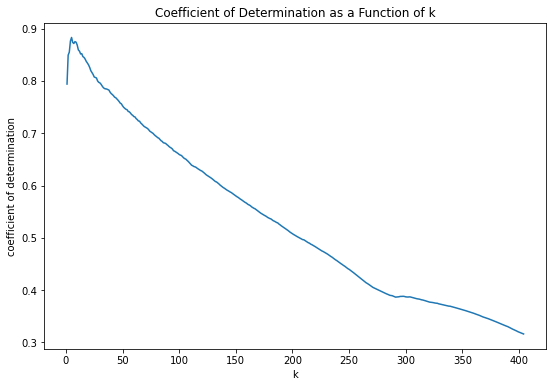

In [15]:
plt.figure(figsize=(9,6))
plt.plot(range(1,len(feat_train_1)+1),scores_1)
plt.xlabel('k')
plt.ylabel('coefficient of determination')
plt.title('Coefficient of Determination as a Function of k')

The overall shape of the coefficient of determination vs. <i>k</i> curve is a little steeper for the current model compared to the previous all-features model, although the decay of coefficient of determination with <i>k</i> looks to be a little smoother for the current model. There is a sharper initial increase in coefficient of determination with <i>k</i> in the current case, and it appears as though the model "starts off" with a higher coefficient of determination at <i>k</i> = 1 than the previous model did. But all in all, the shape of the above plot is about what I'd expect.

<h1> Visualizing the Performance of the KNN Regression and Linear Regression Models for Selected Data Features </h1>

By carefully selecting features to include in my KNN Regression and multi-variable linear regression models, I have been able to build a KNN Regression model which has a higher coefficient of determination than the one I built by including all data features. (The multi-variable linear regression model ended up having a lower coefficient of determination for the chosen features.) Just I did for the all-features regression models, I will make a plot which illustrates how well my new KNN Regression and linear regression models performed. Just to remind you what that illustration was, it was a scatter plot of actual vs. predicted median house value for each house in the test/validation set, along with an actual = predicted line. I will once again plot linear regression prediction values in crimson and KNN Regression predictions in blue.

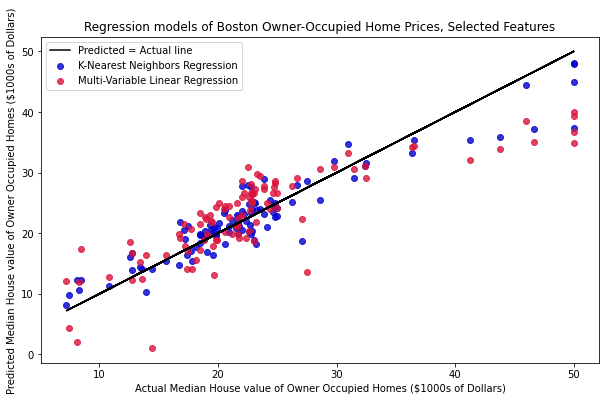

In [16]:
# Set up the actual = predicted line:
equal_line = values_test_1

# Plot actual vs. predicted values:
plt.figure(figsize=(10,6))
plt.scatter(values_test_1, values_predicts_1, color = 'mediumblue', alpha = 0.8)
plt.scatter(values_test_1, lg_1_predict, color = 'crimson', alpha = 0.8)
plt.plot(values_test_1, equal_line, color = 'black')
plt.xlabel('Actual Median House value of Owner Occupied Homes ($1000s of Dollars)')
plt.ylabel('Predicted Median House value of Owner Occupied Homes ($1000s of Dollars)')
plt.title('Regression models of Boston Owner-Occupied Home Prices, Selected Features')
plt.legend(['Predicted = Actual line','K-Nearest Neighbors Regression','Multi-Variable Linear Regression'])

Given that there wasn't a huge change in coefficient of determination in either model going from the previous set of features to this one, it is entirely unsurprising that this plot looks very similar to the previous one. Both models still do a poor job of predicting median house value at high house value, and there is still a fair amount of scatter about the predicted = actual line between median house values of about \\$20,000 and about \\$30,000. However, at least visually, the KNN Regression model's data points do seem to lie closer to the predicted = actual line than they did before.

<h1> Conclusions </h1>

In this project, I attempted to predict median house values for homes in the historic Boston housing data set of scikit-learn. To do this, I constructed two different regression models: one was a multi-variable linear regression model, and the other was a K-Nearest Neighbours (KNN) Regression model. One pair of models was constructed using all features in the data set; another pair was constructed using carefully chosen features in the data set. In both cases, the KNN Regression model outperforms the multi-variable linear regression model in terms of goodness of fit. At its best (as judged by comparing actual house values in the test/validation set to the model predicted ones), the KNN Regression model I constructed had a coefficient of determination of about 0.9. This indicates that about 10% of the variation in median house values could not be accounted for by the variables I fed to the models. It does seem to me that there are house characteristics which the data I received cannot account for -- state of upkeep, recent exterior improvements, major interior renovations, etc. -- and which factor in to house values. I don't pretend to know whether these characteristics can account for that 10% variation in house values, but it seems reasonable to me that they would exist and contribute to at least some of that variation. Thus I conclude that the models I built do a reasonable job of predicting median house values, but that there is some house value variation which cannot be accounted for by the data.